# Image classification



This follows a basic machine learning workflow:

1. Examine and understand data
2. Build an input pipeline
3. Build the model
4. Train the model
5. Test the model
6. Improve the model and repeat the process

## Setup

Import TensorFlow and other necessary libraries:

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

2024-04-01 21:36:52.153909: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-01 21:36:52.430626: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-01 21:36:52.474680: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-04-01 21:36:52.474701: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore 

In [8]:
import pathlib

data_dir = pathlib.Path('/home/aswin/Downloads/Final+eyes/Train/').with_suffix('')

You should now have a dataset available.

In [2]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

NameError: name 'data_dir' is not defined

Here are some images:

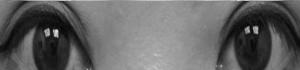

In [10]:
normal = list(data_dir.glob('normal/*'))
PIL.Image.open(str(normal[10]))

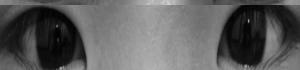

In [11]:
PIL.Image.open(str(normal[5]))

Another class:

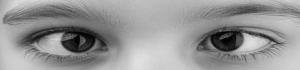

In [14]:
esotropia = list(data_dir.glob('esotropia/*'))
PIL.Image.open(str(esotropia[0]))

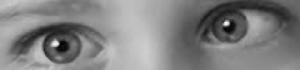

In [15]:
PIL.Image.open(str(esotropia[1]))

## Load data using a Keras utility

Next, load these images off disk using the helpful `tf.keras.utils.image_dataset_from_directory` utility. This will take you from a directory of images on disk to a `tf.data.Dataset` in just a couple lines of code. If you like, you can also write your own data loading code from scratch by visiting the [Load and preprocess images](../load_data/images.ipynb) tutorial.

### Create a dataset

Define some parameters for the loader:

In [16]:
batch_size = 12
img_height = 70
img_width = 300

It's good practice to use a validation split when developing your model. Use 80% of the images for training and 20% for validation.

In [19]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 169 files belonging to 5 classes.
Using 136 files for training.


In [20]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 169 files belonging to 5 classes.
Using 33 files for validation.


You can find the class names in the `class_names` attribute on these datasets. These correspond to the directory names in alphabetical order.

In [21]:
class_names = train_ds.class_names
print(class_names)

['esotropia', 'exotropia', 'hypertropia', 'hypotropia', 'normal']


## Visualize the data

Here are the first nine images from the training dataset:

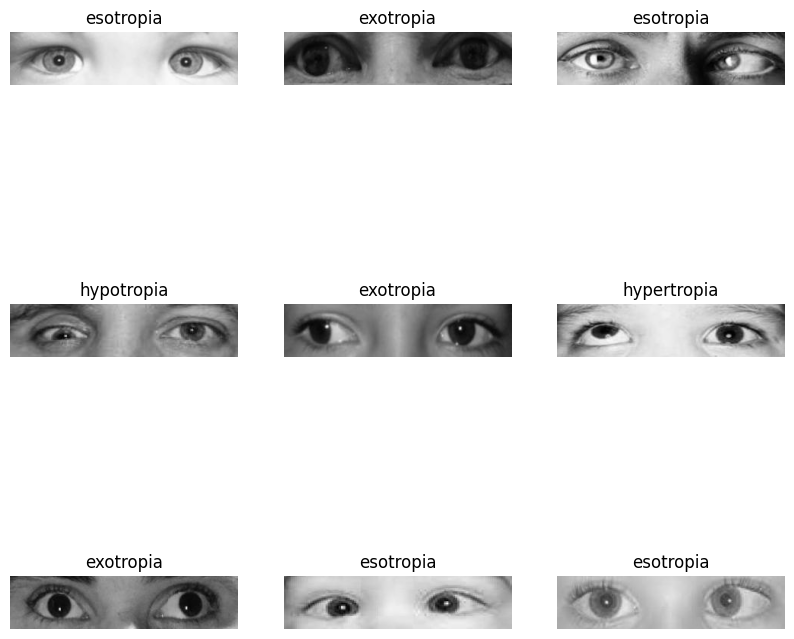

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

You will pass these datasets to the Keras `Model.fit` method for training later in this tutorial. If you like, you can also manually iterate over the dataset and retrieve batches of images:

In [23]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(12, 70, 300, 3)
(12,)


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

You can call `.numpy()` on the `image_batch` and `labels_batch` tensors to convert them to a `numpy.ndarray`.


## Configure the dataset for performance

Make sure to use buffered prefetching, so you can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data:

- `Dataset.cache` keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.
- `Dataset.prefetch` overlaps data preprocessing and model execution while training.

Interested readers can learn more about both methods, as well as how to cache data to disk in the *Prefetching* section of the [Better performance with the tf.data API](../../guide/data_performance.ipynb) guide.

In [24]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Standardize the data

The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network; in general you should seek to make your input values small.

Here, you will standardize values to be in the `[0, 1]` range by using `tf.keras.layers.Rescaling`:

In [25]:
normalization_layer = layers.Rescaling(1./255)

There are two ways to use this layer. You can apply it to the dataset by calling `Dataset.map`:

In [27]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.8313726


Or, you can include the layer inside your model definition, which can simplify deployment. Use the second approach here.

Note: You previously resized images using the `image_size` argument of `tf.keras.utils.image_dataset_from_directory`. If you want to include the resizing logic in your model as well, you can use the `tf.keras.layers.Resizing` layer.

## A basic Keras model

### Create the model

The Keras [Sequential](https://www.tensorflow.org/guide/keras/sequential_model) model consists of three convolution blocks (`tf.keras.layers.Conv2D`) with a max pooling layer (`tf.keras.layers.MaxPooling2D`) in each of them. There's a fully-connected layer (`tf.keras.layers.Dense`) with 128 units on top of it that is activated by a ReLU activation function (`'relu'`). This model has not been tuned for high accuracy; the goal of this tutorial is to show a standard approach.

In [28]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

### Compile the model

For this tutorial, choose the `tf.keras.optimizers.Adam` optimizer and `tf.keras.losses.SparseCategoricalCrossentropy` loss function. To view training and validation accuracy for each training epoch, pass the `metrics` argument to `Model.compile`.

In [29]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Model summary

View all the layers of the network using the Keras `Model.summary` method:

In [30]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 70, 300, 3)        0         
                                                                 
 conv2d (Conv2D)             (None, 70, 300, 16)       448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 35, 150, 16)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 35, 150, 32)       4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 17, 75, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 17, 75, 64)        1

### Train the model

Train the model for 10 epochs with the Keras `Model.fit` method:

In [33]:
epochs=20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
12/12 [==============================] - 1s 47ms/step - loss: 0.0261 - accuracy: 0.9853 - val_loss: 2.0469 - val_accuracy: 0.6364
Epoch 2/20
12/12 [==============================] - 1s 44ms/step - loss: 0.0227 - accuracy: 1.0000 - val_loss: 3.2265 - val_accuracy: 0.5455
Epoch 3/20
12/12 [==============================] - 1s 43ms/step - loss: 0.2444 - accuracy: 0.9044 - val_loss: 1.6646 - val_accuracy: 0.5758
Epoch 4/20
12/12 [==============================] - 1s 42ms/step - loss: 0.2595 - accuracy: 0.8971 - val_loss: 1.1335 - val_accuracy: 0.6061
Epoch 5/20
12/12 [==============================] - 1s 43ms/step - loss: 0.0696 - accuracy: 0.9926 - val_loss: 2.7895 - val_accuracy: 0.6364
Epoch 6/20
12/12 [==============================] - 1s 43ms/step - loss: 0.0542 - accuracy: 0.9706 - val_loss: 1.6464 - val_accuracy: 0.6970
Epoch 7/20
12/12 [==============================] - 1s 43ms/step - loss: 0.0482 - accuracy: 0.9926 - val_loss: 1.7533 - val_accuracy: 0.6970
Epoch 8/20
12

## Visualize training results

Create plots of the loss and accuracy on the training and validation sets:

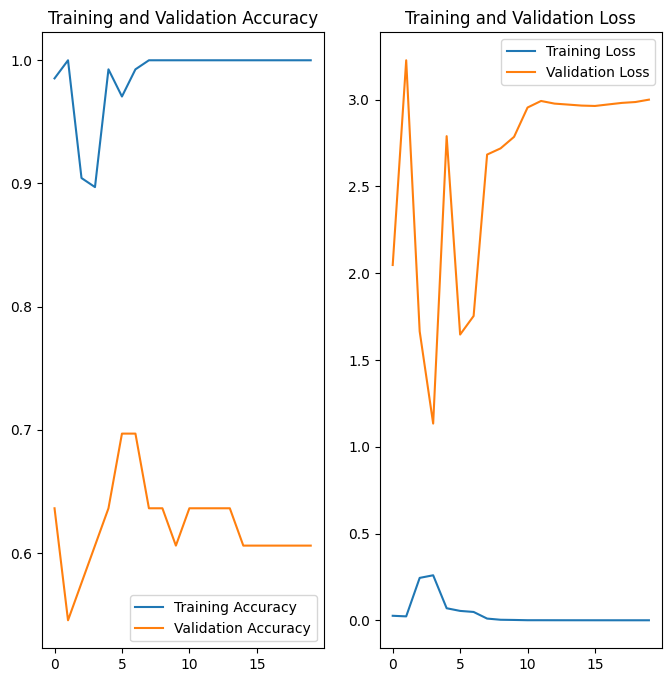

In [34]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

The plots show that training accuracy and validation accuracy are off by large margins, and the model has achieved only around 60% accuracy on the validation set.

The following tutorial sections show how to inspect what went wrong and try to increase the overall performance of the model.

## Predict on new data

Use your model to classify an image that wasn't included in the training or validation sets.

Note: Data augmentation and dropout layers are inactive at inference time.

In [36]:
image_path = "/home/aswin/Downloads/Final+eyes/Train/hypotropia/images-7_jpeg.rf.45ac10f9728289884940c69991ca8223.jpg"

img = tf.keras.utils.load_img(
    image_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predict0.6061ions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 17ms/step
This image most likely belongs to hypotropia with a 99.99 percent confidence.


In [37]:
model.save('/home/aswin/Desktop/model.h5', save_format='h5')